In [ ]:
import pandas as pd
df = pd.read_csv('/Users/kai/Desktop/qs/data_csv_distinct_0606/000001.SZ.csv')[['TRADE_DT', 'S_DQ_CLOSE']]
df['TRADE_DT'] = pd.to_datetime(df['TRADE_DT'], format='%Y%m%d')

In [ ]:
df['shift_date'] = df['TRADE_DT'].shift()
display(df)
df.dropna(subset=['shift_date'], inplace=True)
df

In [7]:
import time 
start1 = time.time()
for i in range(10000):
    df_cross = pd.DataFrame()
    df_cross=df[(df['golden_cross']==1)|(df['death_cross']==1)]
end1 = time.time()
print(end1-start1)
start2 = time.time()
for i in range(10000):
    df_cross = pd.DataFrame()
    df_cross=df[(df['golden_cross']==1)|(df['death_cross']==1)].copy()
end2 = time.time()
print(end2-start2)

3.387718915939331
3.586271047592163


Current file path is /Users/kai/Desktop/qs/data_csv_distinct_0606/000001.SZ.csv


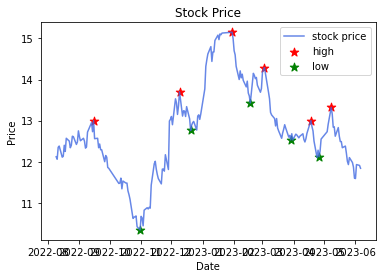

In [1]:
import high_low_xuejie_zuhui as hl
import pandas as pd
filename = '000001.SZ.csv'
df = hl.df_init(filename)
a = hl.find_high_low(df, filename=filename, save_data = False, draw_n_days=200, draw=True)

In [14]:
df1 = df.head(5)
df2 = df1[df1['TRADE_DT'] > '2000-01-05']
print(df2.iloc[1,-1])
df2.iat[1,-1] = 9
print(df2.iloc[1,-1])
display(df1)
display(df2)

0
9


,TRADE_DT,S_DQ_CLOSE,macd,macd_signal,golden_cross,death_cross
0,2000-01-04,18.29,NaN,NaN,0,0
1,2000-01-05,18.06,NaN,NaN,0,0
2,2000-01-06,18.78,NaN,NaN,0,0
3,2000-01-07,19.54,NaN,NaN,0,0
4,2000-01-10,20.14,NaN,NaN,0,0


,TRADE_DT,S_DQ_CLOSE,macd,macd_signal,golden_cross,death_cross
2,2000-01-06,18.78,NaN,NaN,0,0
3,2000-01-07,19.54,NaN,NaN,0,9
4,2000-01-10,20.14,NaN,NaN,0,0


In [ ]:
import sys
import talib
for i in sys.path:
    print(i)